Template for Cleaning the Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from collections import Counter
from imblearn.over_sampling import SMOTE
import os
from datetime import datetime
from sklearn.decomposition import PCA

2023-06-20 03:19:03.212143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path = "Data/train"
list_files = list()
df = pd.DataFrame()
for file in os.listdir(path):
    if file.endswith('.csv'):
        list_files.append(file)
        
list_files

['19_7.csv',
 '19_1.csv',
 '19_2.csv',
 '19_3.csv',
 '35_1.csv',
 '35_2.csv',
 '34_3.csv',
 '34_1.csv',
 '36_3.csv']

In [4]:
list_files[4]

'35_1.csv'

In [5]:
df = pd.read_csv(path + '/' + list_files[4])
df.head()

,ID,Tune Date,System,Test ID,69 m/z,70 m/z,219 m/z,220 m/z,502 m/z,503 m/z,...,Emission,EM Volts,Ent Lens,Ion Focus,Repeller,Ent Lens offset,Filament,Width219,Temp,Condition
0,1,10/08/2020 2:34 PM (UTC+10:00),35,1,324224,3632,251008,11280,17232,1507,...,34.6,1621,20.18,90.3,27.73,14.273,1,-0.019,250,0
1,2,11/08/2020 11:40 AM (UTC+10:00),35,1,401600,4205,309376,13308,20704,2258,...,34.6,1650,20.18,90.3,28.52,14.273,1,-0.022,250,0
2,3,12/08/2020 9:23 AM (UTC+10:00),35,1,354432,3940,268032,11653,17904,1646,...,34.6,1641,20.18,90.3,28.13,14.273,1,-0.021,250,0
3,4,13/08/2020 11:45 AM (UTC+10:00),35,1,437312,5037,335168,14327,21016,2364,...,34.6,1680,22.67,90.3,28.13,14.110,1,-0.020,250,0
4,5,14/08/2020 3:00 PM (UTC+10:00),35,1,451200,4897,347840,14616,21864,2533,...,34.6,1687,22.67,90.3,28.52,14.110,1,-0.019,250,0


In [6]:
df.columns

Index(['ID', 'Tune Date', 'System', 'Test ID', '69 m/z', '70 m/z', '219 m/z',
       '220 m/z', '502 m/z', '503 m/z', 'Amu gain', 'Amu offset', 'Emission',
       'EM Volts', 'Ent Lens', 'Ion Focus', 'Repeller', 'Ent Lens offset',
       'Filament', 'Width219', 'Temp', 'Condition'],
      dtype='object')

* Clean inconsistant Tune Date

In [7]:
df.drop(['Filament'], axis=1, inplace=True) # Drop Filament column
df.drop(['Emission'], axis=1, inplace=True) # Drop Emission column
df.drop(['Temp'], axis=1, inplace=True) # Drop Temp column
df.drop(['Test ID'], axis=1, inplace=True) # Drop Test ID column

df['502_to_69_ratio'] = df['502 m/z'] / df['69 m/z'] # Create new column with ratio of 502 m/z to 69 m/z

############################################
#clean the datetime format
def clean_date(date):
    if 'UTC' in date:
        date = date.split('(')[0]
        date = date.split("  ")[0]
    return date

def convert_to_datetime(date):
    date_string = date
    date_format = '%d/%m/%Y %I:%M %p'

    datetime_obj = datetime.strptime(date_string, date_format)
    formatted_datetime = datetime_obj.strftime('%Y-%m-%d %H:%M:%S')
    return formatted_datetime

df['Tune Date'] = df['Tune Date'].apply(lambda x: clean_date(x))
df['Tune Date'] = df['Tune Date'].apply(lambda x: convert_to_datetime(x))
df['Tune Date'] = pd.to_datetime(df['Tune Date'])
df['total_hour_diff'] = df['Tune Date'].diff().apply(lambda x: x.total_seconds()/3600) # new column with total hour difference

df.drop(['Tune Date'], axis=1, inplace=True) # Drop Tune Date column
############################################


# Perform PCA on the highly correlated columns
pca = PCA(n_components=1)
components = pca.fit_transform(df[['69 m/z', '70 m/z']])
print(pca.explained_variance_ratio_)
df['PCA_Component 69 m/z'] = components

pca = PCA(n_components=1)
components = pca.fit_transform(df[['219 m/z', '220 m/z']])
print(pca.explained_variance_ratio_)
df['PCA_Component 219 m/z'] = components

pca = PCA(n_components=1)
components = pca.fit_transform(df[['502 m/z', '503 m/z']])
print(pca.explained_variance_ratio_)
df['PCA_Component 502 m/z'] = components


# add columns for pct change
def precent_change(col_name , periods):
    df[col_name + " pct change " + str(periods) + 'days'] = df[col_name].pct_change(periods=periods) * 100
    return df[col_name + " pct change " + str(periods) + 'days']

for i in range (5):
    precent_change('EM Volts', i+1)
for i in range (5):
    precent_change('502_to_69_ratio', i+1)

df.head()

[0.99997643]
[0.99985427]
[0.99698234]


,ID,System,69 m/z,70 m/z,219 m/z,220 m/z,502 m/z,503 m/z,Amu gain,Amu offset,...,EM Volts pct change 1days,EM Volts pct change 2days,EM Volts pct change 3days,EM Volts pct change 4days,EM Volts pct change 5days,502_to_69_ratio pct change 1days,502_to_69_ratio pct change 2days,502_to_69_ratio pct change 3days,502_to_69_ratio pct change 4days,502_to_69_ratio pct change 5days
0,1,35,324224,3632,251008,11280,17232,1507,2656,133.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,35,401600,4205,309376,13308,20704,2258,2655,133.563,...,1.789019,NaN,NaN,NaN,NaN,-3.000381,NaN,NaN,NaN,NaN
2,3,35,354432,3940,268032,11653,17904,1646,2657,133.438,...,-0.545455,1.233806,NaN,NaN,NaN,-2.015679,-4.955582,NaN,NaN,NaN
3,4,35,437312,5037,335168,14327,21016,2364,2655,134.000,...,2.376600,1.818182,3.639729,NaN,NaN,-4.864737,-6.782359,-9.579243,NaN,NaN
4,5,35,451200,4897,347840,14616,21864,2533,2657,133.750,...,0.416667,2.803169,2.242424,4.071561,NaN,0.832808,-4.072443,-6.006034,-8.826212,NaN


In [13]:
df.fillna(0, inplace=True) # fill NaN values with 0
df

,ID,System,69 m/z,70 m/z,219 m/z,220 m/z,502 m/z,503 m/z,Amu gain,Amu offset,...,EM Volts pct change 1days,EM Volts pct change 2days,EM Volts pct change 3days,EM Volts pct change 4days,EM Volts pct change 5days,502_to_69_ratio pct change 1days,502_to_69_ratio pct change 2days,502_to_69_ratio pct change 3days,502_to_69_ratio pct change 4days,502_to_69_ratio pct change 5days
0,1,35,324224,3632,251008,11280,17232,1507,2656,133.625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,35,401600,4205,309376,13308,20704,2258,2655,133.563,...,1.789019,0.000000,0.000000,0.000000,0.000000,-3.000381,0.000000,0.000000,0.000000,0.000000
2,3,35,354432,3940,268032,11653,17904,1646,2657,133.438,...,-0.545455,1.233806,0.000000,0.000000,0.000000,-2.015679,-4.955582,0.000000,0.000000,0.000000
3,4,35,437312,5037,335168,14327,21016,2364,2655,134.000,...,2.376600,1.818182,3.639729,0.000000,0.000000,-4.864737,-6.782359,-9.579243,0.000000,0.000000
4,5,35,451200,4897,347840,14616,21864,2533,2657,133.750,...,0.416667,2.803169,2.242424,4.071561,0.000000,0.832808,-4.072443,-6.006034,-8.826212,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,69,35,374080,3858,308608,13740,20944,2098,2655,134.063,...,-1.019253,-1.187111,-0.171331,-0.738217,-0.625355,-4.942749,1.576345,-31.173483,-0.879345,2.048948
69,70,35,325440,3489,272128,11432,18872,1792,2656,133.938,...,0.343249,-0.679502,-0.847937,0.171331,-0.397501,3.574264,-1.545151,5.206952,-28.713441,2.663489
70,71,35,427392,4329,349440,15164,27784,2765,2655,134.000,...,2.508552,2.860412,1.812005,1.639344,2.684180,12.104071,16.110967,10.371894,17.941276,-20.084865
71,72,35,269952,3098,222528,10246,16920,1824,2655,133.750,...,-4.393771,-1.995439,-1.659039,-2.661382,-2.826456,-3.584817,8.085345,11.948601,6.415263,13.713297


Text(0, 0.5, 'Cumulative explained variance')

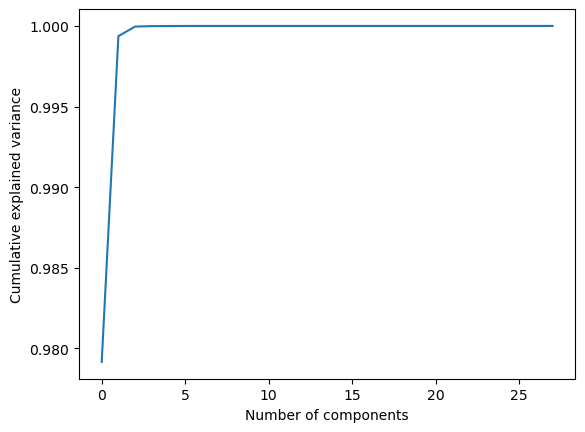

In [15]:
pca_df = df.drop(['Condition'], axis=1)
resize_pca = int(df.shape[1] * 0.9)


pca = PCA(n_components=resize_pca)
pca.fit(pca_df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [7]:
# plot correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


/Users/ching/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:3925: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/ching/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:3926: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,ID,System,69 m/z,70 m/z,219 m/z,220 m/z,502 m/z,503 m/z,Amu gain,Amu offset,EM Volts,Ent Lens,Ion Focus,Repeller,Ent Lens offset,Width219,Condition,502_to_69_ratio,total_hour_diff,PCA_Component 69 m/z,PCA_Component 219 m/z,PCA_Component 502 m/z,EM Volts pct change 1days,EM Volts pct change 2days,EM Volts pct change 3days,EM Volts pct change 4days,EM Volts pct change 5days,502_to_69_ratio pct change 1days,502_to_69_ratio pct change 2days,502_to_69_ratio pct change 3days,502_to_69_ratio pct change 4days,502_to_69_ratio pct change 5days
ID,1.000000,nan,-0.009184,-0.059779,0.082989,0.100175,0.097000,0.180565,0.131263,0.448317,0.798197,0.254299,nan,-0.606695,-0.524325,-0.176905,0.067704,0.156682,0.308952,0.009191,-0.083027,-0.098110,-0.071906,-0.139473,-0.180118,-0.206492,-0.235993,0.075435,0.076327,0.083819,0.072318,0.042957
System,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
69 m/z,-0.009184,nan,1.000000,0.918123,0.959089,0.930194,0.725639,0.725230,-0.130937,-0.109943,0.320906,0.132258,nan,-0.032567,-0.014856,-0.191605,0.113044,-0.047204,0.035230,-1.000000,-0.959104,-0.726663,0.649962,0.617554,0.530262,0.425430,0.335586,-0.086152,-0.053780,0.061306,-0.108523,-0.105733
70 m/z,-0.059779,nan,0.918123,1.000000,0.885826,0.863605,0.668895,0.641121,-0.116276,-0.207774,0.255357,0.125838,nan,0.000048,0.022427,-0.214297,0.083754,-0.033045,-0.030882,-0.918144,-0.885848,-0.669520,0.641041,0.621388,0.508703,0.423618,0.320276,-0.053632,-0.067802,0.055262,-0.110680,-0.062865
219 m/z,0.082989,nan,0.959089,0.885826,1.000000,0.961613,0.844793,0.820319,-0.153095,-0.070680,0.335484,0.122330,nan,-0.054322,-0.057557,-0.224261,0.173089,0.172196,0.128982,-0.959090,-1.000000,-0.845706,0.622180,0.587522,0.485198,0.345497,0.254838,0.005651,0.044866,0.145542,0.004344,0.007852
220 m/z,0.100175,nan,0.930194,0.863605,0.961613,1.000000,0.782082,0.781222,-0.128228,-0.088256,0.320050,0.090205,nan,-0.084799,-0.023572,-0.223152,0.153154,0.116937,0.151559,-0.930196,-0.961753,-0.783180,0.599698,0.541699,0.440868,0.315300,0.201718,-0.067096,0.003207,0.108819,-0.039189,-0.013442
502 m/z,0.097000,nan,0.725639,0.668895,0.844793,0.782082,1.000000,0.876865,-0.280745,-0.044197,0.221006,0.004106,nan,0.097158,-0.049635,-0.369564,0.215450,0.648659,0.184315,-0.725640,-0.844737,-0.999984,0.501300,0.494543,0.463963,0.249770,0.203367,0.346700,0.374989,0.474607,0.394240,0.355489
503 m/z,0.180565,nan,0.725230,0.641121,0.820319,0.781222,0.876865,1.000000,-0.223830,0.012115,0.306717,-0.041726,nan,0.121395,-0.061690,-0.255231,0.216732,0.480268,0.205025,-0.725226,-0.820304,-0.879540,0.490467,0.432640,0.408039,0.224819,0.140798,0.257941,0.354777,0.398624,0.361242,0.362916
Amu gain,0.131263,nan,-0.130937,-0.116276,-0.153095,-0.128228,-0.280745,-0.223830,1.000000,-0.167673,0.085814,-0.157586,nan,-0.001151,0.024158,0.377708,-0.010278,-0.255390,-0.032524,0.130936,0.153059,0.280481,-0.064525,-0.167162,-0.352897,-0.200295,-0.143856,-0.095489,-0.215827,-0.197139,-0.040725,-0.060629
Amu offset,0.448317,nan,-0.109943,-0.207774,-0.070680,-0.088256,-0.044197,0.012115,-0.167673,1.000000,0.358232,0.269730,nan,-0.043246,-0.442633,0.452500,-0.066909,0.088692,0.290610,0.109957,0.070718,0.043604,-0.090411,0.023704,0.031392,-0.198115,-0.233238,0.167503,0.237138,-0.058623,0.081066,0.085710


In [8]:
# importing packages
import seaborn
import matplotlib.pyplot as plt
 
# pairplot with hue for condition
seaborn.pairplot(df, hue ='Condition')
# to show
plt.show()

KeyboardInterrupt: 